In [9]:
import scipy.signal
import functools
import multiprocessing
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import sys

sys.path.append('../src/')
import signal_processing

import tensorflow as tf

tf.config.set_visible_devices([], 'GPU')
cae = tf.saved_model.load('../output/model')

In [10]:
def mean_relative_error(y, x):
    return np.mean(np.absolute(y - x) / (1 + np.absolute(y)))

def mean_absolute_error(y, x):
    return np.mean(np.absolute(y - x))

def mean_squared_error(y, x):
    return np.mean(np.square(y - x))

def grid_search(f, x, y, g, parameters):
    grid = itertools.product(*parameters)
    best_error = float('inf')
    for p in grid:
        if g is not None:
            x_ = g(x)
            x_ = f(x_, *p)
        else:
            x_ = f(x, *p)
        mre = mean_relative_error(y, x_)
        mae = mean_absolute_error(y, x_)
        mse = mean_squared_error(y, x_)
        if mae < best_error:
            best_error = mae
            best_mre = mre
            best_mae = mae
            best_param = p
            best_x_ = x_
    
    return best_mre, best_mae, best_param, best_x_


# Hyperparameters to search (via grid-search) 
savgol_lengths = [5, 13, 21, 29, 37, 45, 53, 61, 69, 77, 85, 93,101, 109, 117, 125, 133, 141, 149, 157]
savgol_orders =  [2, 3, 4]
savgol_n_iters = [1, 2, 3]

gaussian_lengths = [5, 13, 21, 29, 37, 45, 53, 61, 69, 77, 85, 93, 101, 109, 117, 125, 133, 141, 149, 157]
gaussian_sigmas = [1, 2, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
gaussian_n_iters = [1, 2, 3]

als_lam = [1e6, 1e7, 1e8, 1e9]
als_p = [1e-2, 1e-3, 1e-4]
als_n_iters = [1, 2, 3]

polynomial_orders = [2, 6, 12, 24, 48]
polynomial_n_iters = [1, 2, 4, 8]

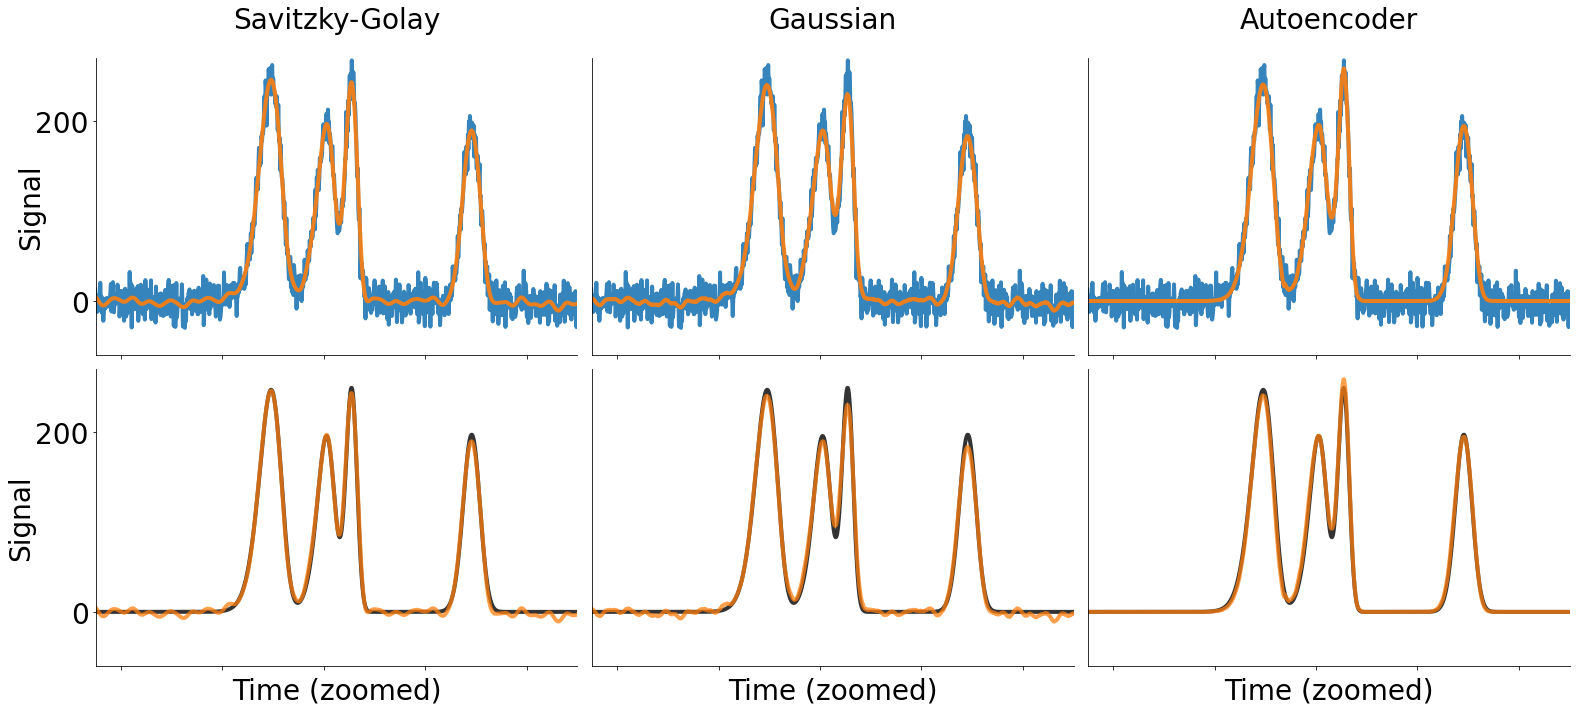

In [11]:

def plot(x, y, r, ax_ids, title, remove_y_axis=True):

    ax[ax_ids[0]].set_ylabel('Signal', fontsize=28, labelpad=-10)
    ax[ax_ids[0]].spines['top'].set_visible(False)
    ax[ax_ids[0]].spines['right'].set_visible(False)
    ax[ax_ids[0]].set_xticklabels([])
    ax[ax_ids[0]].tick_params(axis='both', which='major', labelsize=28)


    ax[ax_ids[1]].set_ylabel('Signal', fontsize=28, labelpad=0)
    ax[ax_ids[1]].set_xlabel('Time (zoomed)', fontsize=28)
    ax[ax_ids[1]].spines['top'].set_visible(False)
    ax[ax_ids[1]].spines['right'].set_visible(False)
    ax[ax_ids[1]].set_xticklabels([])
    ax[ax_ids[1]].tick_params(axis='both', which='major', labelsize=28)

    ax[ax_ids[0]].plot(
        x,
        color='C0',
        alpha=0.9,
        label='Input chromatogram',
        linewidth=4);
    ax[ax_ids[0]].plot(
        r,
        color='C1',
        alpha=0.9,
        label='Reconstructed chromatogram',
        linewidth=4);

    ax[ax_ids[1]].plot(
        y,
        color='black',
        alpha=0.8,
        label='Target chromatogram',
        linewidth=4);
    ax[ax_ids[1]].plot(
        r,
        color='C1',
        alpha=0.75,
        label='Reconstructed chromatogram',
        linewidth=4);


    ax[ax_ids[0]].set_title(title, fontsize=28, pad=30)
    
    ax[ax_ids[0]].set_xlim(1950, 2900)
    ax[ax_ids[1]].set_xlim(1950, 2900)
    ax[ax_ids[0]].set_ylim(-60, 270)
    ax[ax_ids[1]].set_ylim(-60, 270)
    ax[ax_ids[0]].set_yticks([0, 200])
    ax[ax_ids[1]].set_yticks([0, 200])
    
    if remove_y_axis:
        ax[ax_ids[0]].set_yticks([])
        ax[ax_ids[1]].set_yticks([])
        ax[ax_ids[0]].set_ylabel('')
        ax[ax_ids[1]].set_ylabel('')
    
chrom_ID = 4

x1, x2, y = np.load(f'../input/simulations/test_white/chromatogram_{chrom_ID}.npy')

mre1, mae1, param1, x_1 = grid_search(
    f=signal_processing.savgol_filter, 
    x=x1, 
    y=y, 
    g=None, 
    parameters=(savgol_lengths, savgol_orders, savgol_n_iters) # parameters
)

mre2, mae2, param2, x_2 = grid_search(
    f=signal_processing.gaussian_filter, 
    x=x1, 
    y=y,
    g=None, 
    parameters=(gaussian_lengths, gaussian_sigmas, gaussian_n_iters) # parameters
) 

x_0 = cae.smooth(x1.astype('float32'))    

    
fig, ax = plt.subplots(2, 3, figsize=(22, 10))
ax = ax.T.reshape(-1)

plot(x1, y, x_1, [0, 1], 'Savitzky-Golay', False)
plot(x1, y, x_2, [2, 3], 'Gaussian')
plot(x1, y, x_0, [4, 5], 'Autoencoder')

plt.subplots_adjust(hspace=0.1, wspace=0.05)
plt.tight_layout()
# plt.savefig('plots/Figure_4.png', dpi=200)

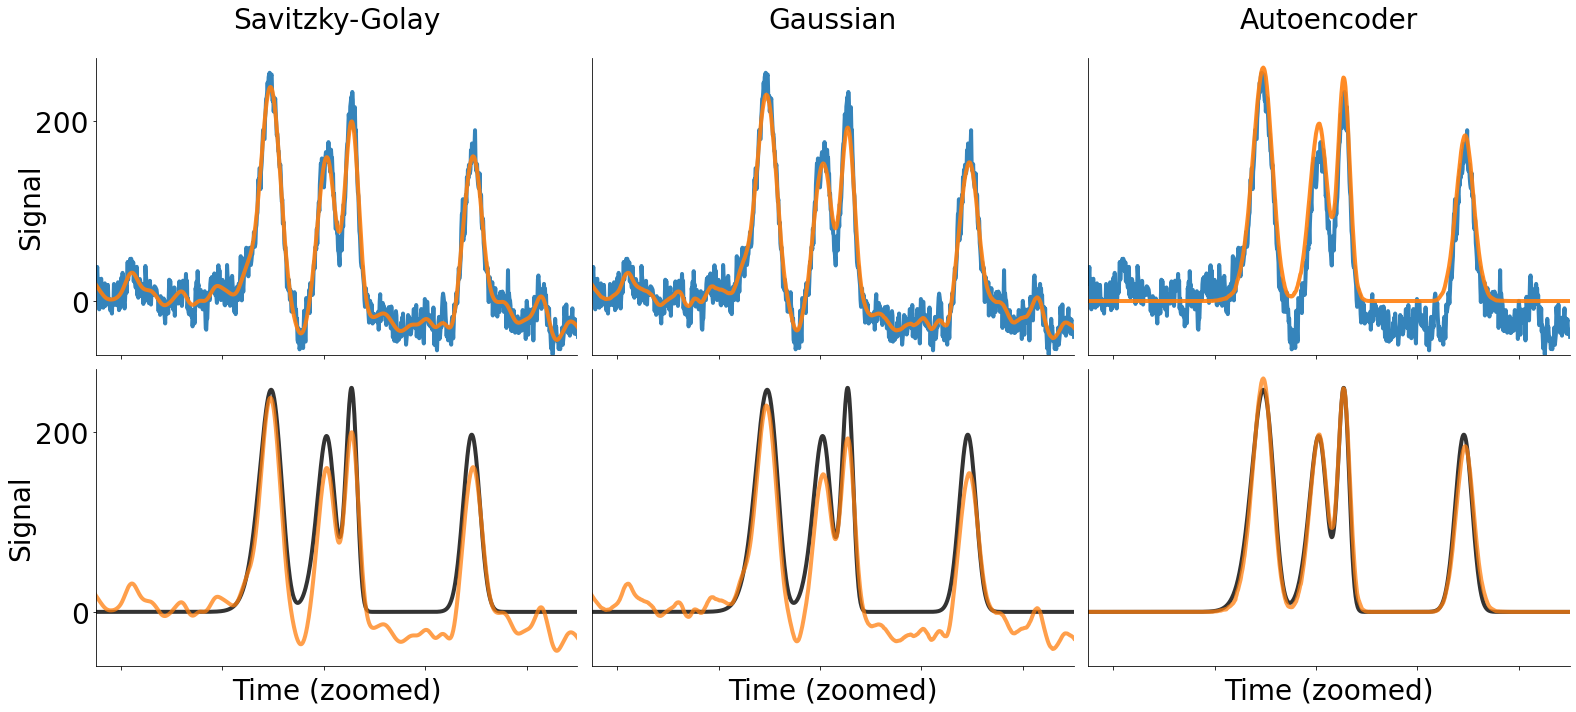

In [12]:

chrom_ID = 4

x1, x2, y = np.load(f'../input/simulations/test_pink/chromatogram_{chrom_ID}.npy')

mre1, mae1, param1, x_1 = grid_search(
    f=signal_processing.savgol_filter, 
    x=x1, 
    y=y, 
    g=None, 
    parameters=(savgol_lengths, savgol_orders, savgol_n_iters) # parameters
)

mre2, mae2, param2, x_2 = grid_search(
    f=signal_processing.gaussian_filter, 
    x=x1, 
    y=y,
    g=None, 
    parameters=(gaussian_lengths, gaussian_sigmas, gaussian_n_iters) # parameters
) 

x_0 = cae.smooth(x1.astype('float32'))    

    
fig, ax = plt.subplots(2, 3, figsize=(22, 10))
ax = ax.T.reshape(-1)

plot(x1, y, x_1, [0, 1], 'Savitzky-Golay', False)
plot(x1, y, x_2, [2, 3], 'Gaussian')
plot(x1, y, x_0, [4, 5], 'Autoencoder')

plt.subplots_adjust(hspace=0.1, wspace=0.05)
plt.tight_layout()
# plt.savefig('plots/Figure_5.png', dpi=200)

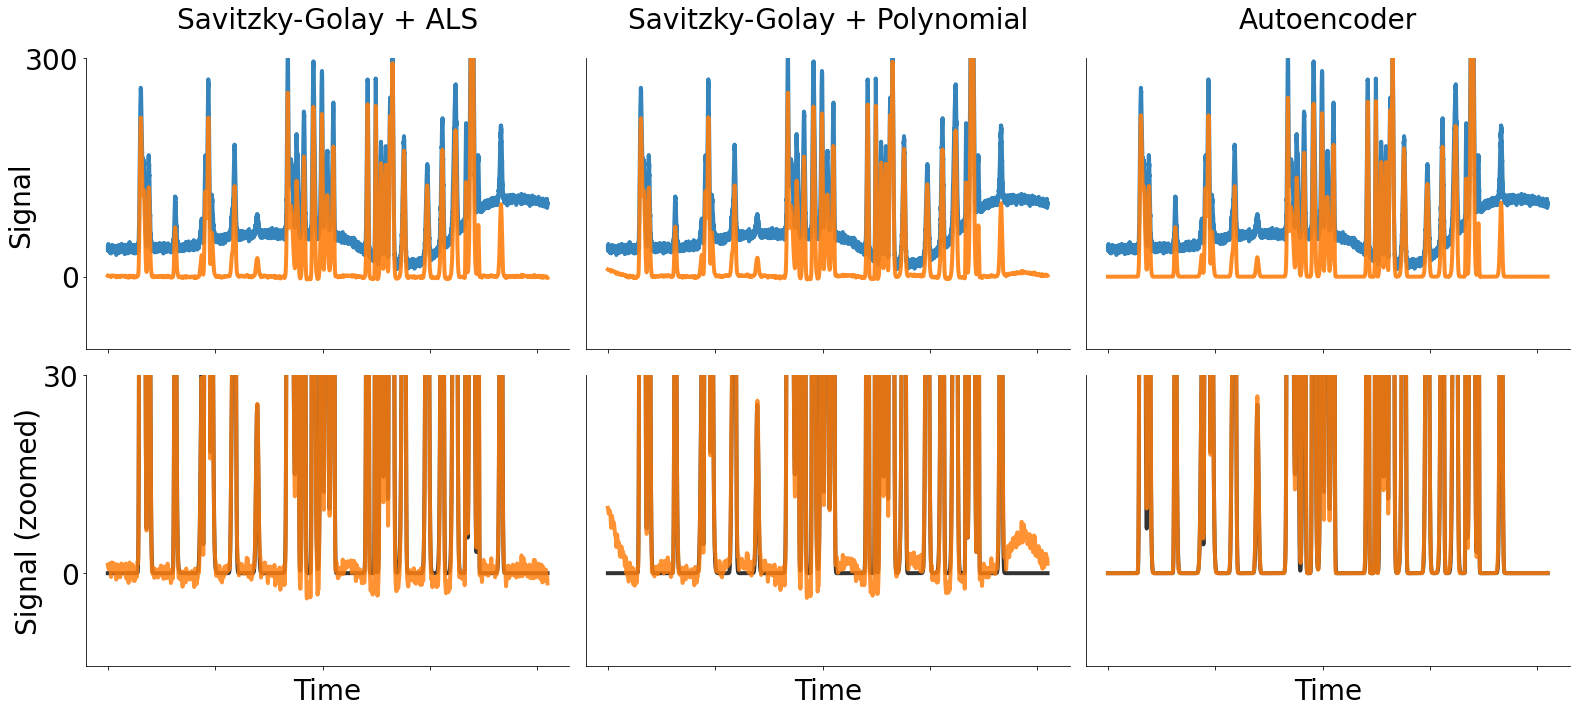

In [13]:

def plot(x, y, r, ax_ids, title, remove_y_axis=True):

    ax[ax_ids[0]].set_ylabel('Signal', fontsize=28, labelpad=-10)
    ax[ax_ids[0]].spines['top'].set_visible(False)
    ax[ax_ids[0]].spines['right'].set_visible(False)
    ax[ax_ids[0]].set_xticklabels([])
    ax[ax_ids[0]].tick_params(axis='both', which='major', labelsize=28)


    ax[ax_ids[1]].set_ylabel('Signal (zoomed)', fontsize=28, labelpad=0)
    ax[ax_ids[1]].set_xlabel('Time', fontsize=28)
    ax[ax_ids[1]].spines['top'].set_visible(False)
    ax[ax_ids[1]].spines['right'].set_visible(False)
    ax[ax_ids[1]].set_xticklabels([])
    ax[ax_ids[1]].tick_params(axis='both', which='major', labelsize=28)

    ax[ax_ids[0]].plot(
        x,
        color='C0',
        alpha=0.9,
        label='Input chromatogram',
        linewidth=4);
    ax[ax_ids[0]].plot(
        r,
        color='C1',
        alpha=0.9,
        label='Reconstructed chromatogram',
        linewidth=4);

    #ax[ax_ids[0]].legend(fontsize=16, frameon=False, loc=3)
    _, ylmax = ax[0].get_ylim()
    ax[ax_ids[0]].set_ylim(-100, 300)

    ax[ax_ids[1]].plot(
        y,
        color='black',
        alpha=0.8,
        label='Target chromatogram',
        linewidth=4);
    ax[ax_ids[1]].plot(
        r,
        color='C1',
        alpha=0.85,
        label='Reconstructed chromatogram',
        linewidth=4);

   # ax[ax_ids[1]].legend(fontsize=16, frameon=False, loc=3)
    _, ylmax = ax[1].get_ylim()
    ax[ax_ids[1]].set_ylim(-14, 23)

    ax[ax_ids[0]].set_yticks([0, 300])
    ax[ax_ids[1]].set_yticks([0, 30])

    ax[ax_ids[0]].set_title(title, fontsize=28, pad=30)
    
    if remove_y_axis:
        ax[ax_ids[0]].set_yticks([])
        ax[ax_ids[1]].set_yticks([])
        ax[ax_ids[0]].set_ylabel('')
        ax[ax_ids[1]].set_ylabel('')
    
    
chrom_ID = 128

x1, x2, y = np.load(f'../input/simulations/test_white/chromatogram_{chrom_ID}.npy')

mre1, mae1, param1, x_1 = grid_search(
    f=signal_processing.savgol_filter, 
    x=x1, 
    y=y, 
    g=None, 
    parameters=(savgol_lengths, savgol_orders, savgol_n_iters) # parameters
)

mre2, mae2, param2, x_2 = grid_search(
    f=signal_processing.gaussian_filter, 
    x=x1, 
    y=y,
    g=None, 
    parameters=(gaussian_lengths, gaussian_sigmas, gaussian_n_iters) # parameters
) 

g = functools.partial(
    signal_processing.savgol_filter, 
    length=param1[0], 
    order=param1[1], 
    n_iter=param1[2]
)

mre3, mae3, param3, x_3 = grid_search(
    f=signal_processing.als_baseline_correction, 
    x=x2, 
    y=y, 
    g=g, 
    parameters=(als_lam, als_p, als_n_iters)
)

mre4, mae4, param4, x_4 = grid_search(
    f=signal_processing.polynomial_baseline_correction, 
    x=x2, 
    y=y, 
    g=g, 
    parameters=(polynomial_orders, polynomial_n_iters)
)

x_5 = cae.smooth(x2.astype('float32'))
    
fig, ax = plt.subplots(2, 3, figsize=(22, 10))
ax = ax.T.reshape(-1)

plot(x2, y, x_3, [0, 1], 'Savitzky-Golay + ALS', False)
plot(x2, y, x_4, [2, 3], 'Savitzky-Golay + Polynomial')
plot(x2, y, x_5, [4, 5], 'Autoencoder')

plt.subplots_adjust(hspace=0.1, wspace=0.05)
plt.tight_layout()
# plt.savefig('plots/Figure_6.png', dpi=200)

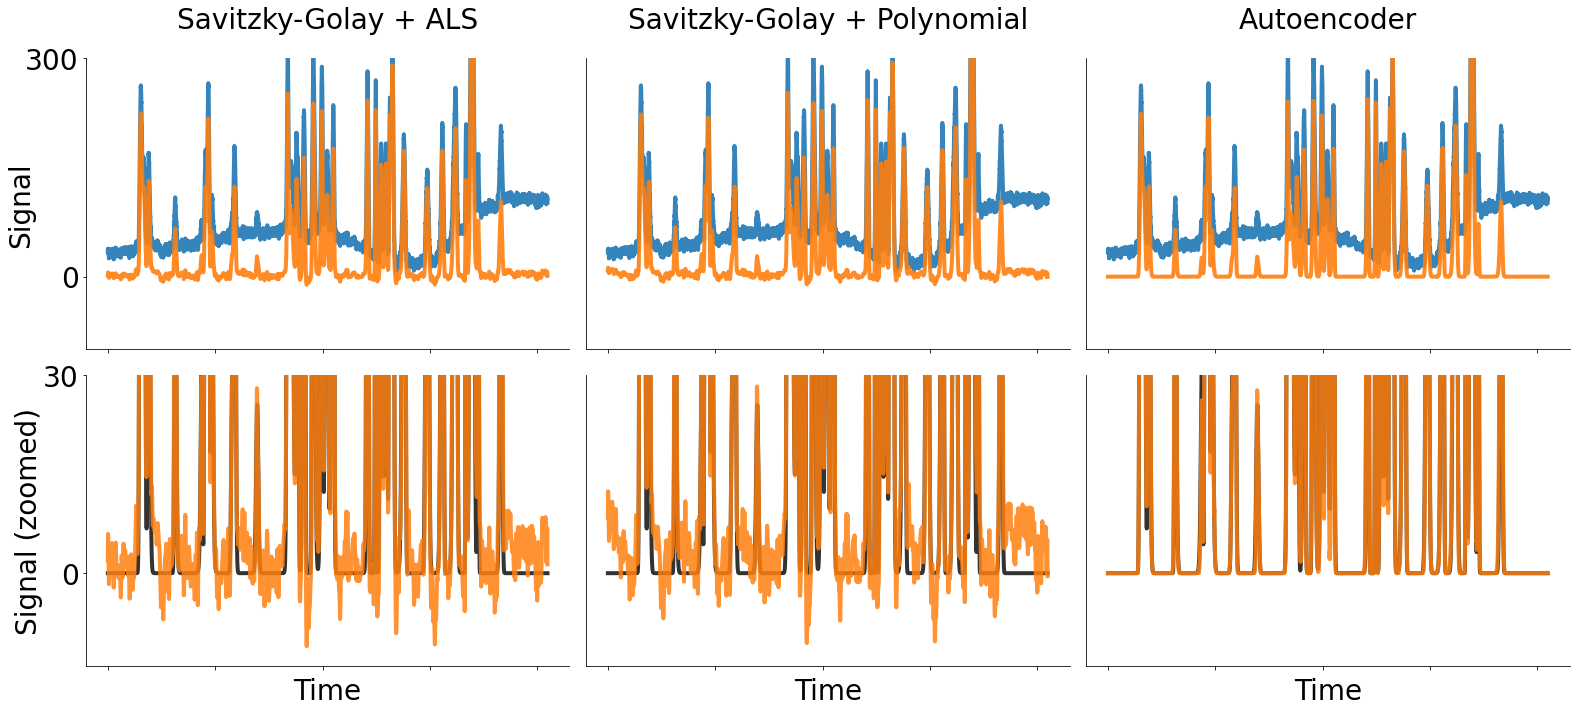

In [14]:

    
chrom_ID = 128

x1, x2, y = np.load(f'../input/simulations/test_pink/chromatogram_{chrom_ID}.npy')

mre1, mae1, param1, x_1 = grid_search(
    f=signal_processing.savgol_filter, 
    x=x1, 
    y=y, 
    g=None, 
    parameters=(savgol_lengths, savgol_orders, savgol_n_iters) # parameters
)

mre2, mae2, param2, x_2 = grid_search(
    f=signal_processing.gaussian_filter, 
    x=x1, 
    y=y,
    g=None, 
    parameters=(gaussian_lengths, gaussian_sigmas, gaussian_n_iters) # parameters
) 

g = functools.partial(
    signal_processing.savgol_filter, 
    length=param1[0], 
    order=param1[1], 
    n_iter=param1[2]
)

mre3, mae3, param3, x_3 = grid_search(
    f=signal_processing.als_baseline_correction, 
    x=x2, 
    y=y, 
    g=g, 
    parameters=(als_lam, als_p, als_n_iters)
)

mre4, mae4, param4, x_4 = grid_search(
    f=signal_processing.polynomial_baseline_correction, 
    x=x2, 
    y=y, 
    g=g, 
    parameters=(polynomial_orders, polynomial_n_iters)
)

x_5 = cae.smooth(x2.astype('float32'))
    
fig, ax = plt.subplots(2, 3, figsize=(22, 10))
ax = ax.T.reshape(-1)

plot(x2, y, x_3, [0, 1], 'Savitzky-Golay + ALS', False)
plot(x2, y, x_4, [2, 3], 'Savitzky-Golay + Polynomial')
plot(x2, y, x_5, [4, 5], 'Autoencoder')

plt.subplots_adjust(hspace=0.1, wspace=0.05)
plt.tight_layout()
# plt.savefig('plots/Figure_7.png', dpi=200)